# Investigation of the Mutual Information in General Quantum Multiple Access Channels 

The contents of this notebook serve to reproduce theoretically trivial bounds regarding the capacith of MACs.

In [1]:
from qnet_context import qnetvo as qnet
from mac_context import *
import pennylane as qml
import pennylane.numpy as np
import matplotlib.pyplot as plt

In [36]:
def local_RY_prep_nodes(num_nodes, num_in):
    return [
        qnet.PrepareNode(num_in, [i], qnet.local_RY, 1)
        for i in range(num_nodes)
    ]

def local_Rot_prep_nodes(num_nodes, num_in):
    return [
        qnet.PrepareNode(
            num_in, [i],
            lambda settings, wires: qml.Rot(*settings, wires=wires),
        3)
        for i in range(num_nodes)
    ]

def local_RY_meas_nodes(num_wires, num_out):
    return [
        qnet.MeasureNode(1, num_out, range(num_wires), qnet.local_RY, num_wires )
    ]
def arb_measure_node(num_wires, num_out):
    return [
        qnet.MeasureNode(1, num_out, range(num_wires), qml.templates.subroutines.ArbitraryUnitary, 4**num_wires-1 )
    ]

def comp_basis_measure_node(num_wires, num_out):
    return [
        qnet.MeasureNode(1, num_out, range(num_wires), lambda settings, wires: None, 0)
    ]

def ghz_basis_measure_node(num_wires, num_out):
    return [
        qnet.MeasureNode(1, num_out, range(num_wires), qml.adjoint(qnet.ghz_state), 0)
    ]

def ea_ghz_state_prep(num_wires):
    return [
        qnet.PrepareNode(1, range(num_wires), qnet.ghz_state, 0)
    ]

def shared_randomness(settings, wires):
    qnet.ghz_state(settings, wires)
    for wire in wires:
        qml.PhaseDamping(1, wires=wire)

def ea_shared_randomness_prep(num_wires):
    return [
        qnet.PrepareNode(1, range(num_wires), shared_randomness, 0)
    ]
    

def ea_zero_prep(num_wires):
    return [
        qnet.PrepareNode(1, range(num_wires), lambda settings, wires: None, 0)
    ]

def ea_local_Rot_meas(num_senders, num_in):
    return [
        qnet.MeasureNode(num_in, 2, [i], lambda settings, wires: qml.Rot(*settings, wires=wires), 3)
        for i in range(num_senders)
    ]



## Local (Quantum or Classical) Communication

iteration :  0 , score :  0.6185175427285765
elapsed time :  0.04538989067077637
iteration :  5 , score :  1.1020599511005411
elapsed time :  0.03700900077819824
iteration :  10 , score :  1.477670350082544
elapsed time :  0.03419017791748047
iteration :  15 , score :  1.642217278794119
elapsed time :  0.03392791748046875
iteration :  20 , score :  1.764387402966264
elapsed time :  0.03768301010131836
iteration :  25 , score :  1.8365657682137595
elapsed time :  0.0338129997253418
iteration :  30 , score :  1.8365882947772358
elapsed time :  0.03568267822265625
iteration :  35 , score :  1.8365885738451082
elapsed time :  0.033637046813964844
iteration :  40 , score :  1.836588620731276
elapsed time :  0.03403306007385254
iteration :  45 , score :  1.83658863153783
elapsed time :  0.03425407409667969
iteration :  50 , score :  1.8365886342083497
elapsed time :  0.03398489952087402
iteration :  55 , score :  1.8365886348796234
elapsed time :  0.033478736877441406
iteration :  60 , score

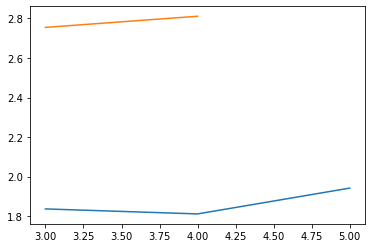

In [91]:

for num_senders in range(2,4):

    max_scores = []
    for num_in in range(3,8-num_senders):

        ansatz = qnet.NetworkAnsatz(
            local_RY_prep_nodes(num_senders, num_in),
            comp_basis_measure_node(num_senders, 2**num_senders)
        )

        priors = [
            np.ones(num_in)/num_in
            for i in range(num_senders)
        ]

        cost = qnet.mutual_info_cost_fn(ansatz, priors)

        opt_dict = qnet.gradient_descent(
            cost,
            ansatz.rand_scenario_settings(),
            sample_width = 5,
            num_steps = 80,
            step_size = 0.5
        )
        
        max_scores.append(opt_dict["opt_score"])
        
    
    plt.plot(range(3,8-num_senders), max_scores)
    
plt.show()
    
    

## Entanglement-Assisted Classical Communication

In [85]:
num_senders = 3
num_in = 3

priors = [
    np.ones(num_in)/num_in
    for i in range(num_senders)
]

ea_ansatz = qnet.NetworkAnsatz(
#     ea_ghz_state_prep(num_senders),
#     ea_shared_randomness_prep(num_senders),
    ea_zero_prep(num_senders),
    ea_local_Rot_meas(num_senders, num_in),
#     dev_kwargs = {"name" : "default.mixed"}
)

# fp_mat = finger_printing_matrix(num_senders, num_in)
# postmap = finger_printing_matrix(num_senders, 2)
# postmap = parity_postmap(num_senders)

ea_cost = qnet.mutual_info_cost_fn(ea_ansatz, priors, static_layer="prepare")

opt_dict = qnet.gradient_descent(
    ea_cost,
    ea_ansatz.rand_scenario_settings(),
    sample_width = 5,
    num_steps = 60,
    step_size = 0.4
)



print("max score : ", opt_dict["opt_score"])

behavior = qnet.behavior_fn(ea_ansatz)
print("optimal behavior : ", np.around(behavior(opt_dict["opt_settings"]), decimals=3))

iteration :  0 , score :  0.9035721601870161
elapsed time :  0.1647779941558838
iteration :  5 , score :  1.5055340000673345
elapsed time :  0.20471692085266113
iteration :  10 , score :  1.8429818446587936
elapsed time :  0.2299511432647705
iteration :  15 , score :  2.311791886574066
elapsed time :  0.19515204429626465
iteration :  20 , score :  2.7081322223393807
elapsed time :  0.19228029251098633
iteration :  25 , score :  2.754887410571917
elapsed time :  0.18143081665039062
iteration :  30 , score :  2.7548874227060045
elapsed time :  0.1693408489227295
iteration :  35 , score :  2.754887419625751
elapsed time :  0.1779778003692627
iteration :  40 , score :  2.7548874165605612
elapsed time :  0.1958460807800293
iteration :  45 , score :  2.7548874151435827
elapsed time :  0.21687602996826172
iteration :  50 , score :  2.754887414606017
elapsed time :  0.2214808464050293
iteration :  55 , score :  2.7548874144149487
elapsed time :  0.18353796005249023
max score :  2.7548874143485

## Sender-Receiver Entanglement Assistance



In [16]:
def entangled_encoder(settings, wires):    
    qnet.ghz_state(settings, wires=wires)
    qml.Rot(*settings, wires=wires[0])

def bell_decoder(settings, wires):
    qml.adjoint(qnet.ghz_state)(settings, wires=wires[0:2])
    qml.adjoint(qnet.ghz_state)(settings, wires=wires[2:4])



num_in = 4
priors = [
    np.ones(4)/4 for i in range(2)
]
    
entangled_prep_nodes = [
    qnet.PrepareNode(num_in, [0,1], entangled_encoder, 3),
    qnet.PrepareNode(num_in, [2,3], entangled_encoder, 3),
]

arb_meas_node = [
    qnet.MeasureNode(1,16,[0,1,2,3],qml.templates.subroutines.ArbitraryUnitary, 4**4-1)
]
bell_meas_node = [
    qnet.MeasureNode(1,16,[0,1,2,3], bell_decoder, 0)
]
local_meas_node = [
    qnet.
]

ea_send_receive_ansatz = qnet.NetworkAnsatz(entangled_prep_nodes, bell_meas_node)

ea_send_receive_cost = qnet.mutual_info_cost_fn(ea_send_receive_ansatz, priors)

ea_send_receive_opt_dict = qnet.gradient_descent(
    ea_send_receive_cost,
    ea_send_receive_ansatz.rand_scenario_settings(),
    sample_width = 5,
    num_steps = 50,
    step_size = 0.5,
)


iteration :  0 , score :  0.8182115079022658
elapsed time :  0.1476609706878662
iteration :  5 , score :  2.352150376395662
elapsed time :  0.17268610000610352
iteration :  10 , score :  3.4419504100585616
elapsed time :  0.14547085762023926
iteration :  15 , score :  3.828418188167208
elapsed time :  0.14538908004760742
iteration :  20 , score :  3.978309592548074
elapsed time :  0.14959502220153809
iteration :  25 , score :  3.999474000480946
elapsed time :  0.15810084342956543
iteration :  30 , score :  3.9994684629883555
elapsed time :  0.1463451385498047
iteration :  35 , score :  3.999467810972953
elapsed time :  0.1446540355682373
iteration :  40 , score :  3.9994677416929942
elapsed time :  0.14492487907409668
iteration :  45 , score :  3.9994677345924634
elapsed time :  0.14676594734191895


In [79]:
def ghz3_prep(settings, wires):
    qnet.ghz_state(settings, wires[0:2])
    qnet.ghz_state(settings, wires[2:4])

#     qml.Rot(*settings[0:3], wires=wires[0])
#     qml.Rot(*settings[3:6], wires=wires[1])
    qml.RZ(settings[0], wires=wires[0])
    qml.RZ(settings[1], wires=wires[2])

    qml.RY(settings[2], wires=wires[0])
    qml.RY(settings[3], wires=wires[2])
    
#     qml.RZ(settings[4], wires=wires[0])
#     qml.RZ(settings[5], wires=wires[2])

def ghz4_meas(settings, wires):
    qml.adjoint(qnet.ghz_state)(settings, wires[0:2])
    qml.adjoint(qnet.ghz_state)(settings, wires[2:4])

num_in = 4
num_senders = 2

priors = [
    np.ones(num_in)/num_in for i in range(num_senders)
]
ghz3_prep_nodes = [
    qnet.PrepareNode(num_in**num_senders, [0,1,2,3], ghz3_prep, 4)
]

ghz3_meas_nodes = [
    qnet.MeasureNode(1, 16, [0,1,2,3], ghz4_meas, 0)
]

ghz3_ansatz = qnet.NetworkAnsatz(
    ghz3_prep_nodes,
    ghz3_meas_nodes
)

ghz3_cost = qnet.mutual_info_cost_fn(ghz3_ansatz, priors)

ghz3_opt_dict = qnet.gradient_descent(
    ghz3_cost,
    ghz3_ansatz.rand_scenario_settings(),
    sample_width = 5,
    num_steps = 150,
    step_size = 0.8,
)

behavior = qnet.behavior_fn(ghz3_ansatz)
print("optimal behavior : ", np.around(behavior(ghz3_opt_dict["opt_settings"]), decimals=3))


iteration :  0 , score :  1.7703943238447675
elapsed time :  0.14717626571655273
iteration :  5 , score :  2.147780491914224
elapsed time :  0.14116787910461426
iteration :  10 , score :  2.478137455380364
elapsed time :  0.16992592811584473
iteration :  15 , score :  2.77112264846198
elapsed time :  0.16218805313110352
iteration :  20 , score :  3.0201501027681337
elapsed time :  0.16847705841064453
iteration :  25 , score :  3.2050116612377257
elapsed time :  3.553828001022339
iteration :  30 , score :  3.3268763304816966
elapsed time :  0.13704490661621094
iteration :  35 , score :  3.4112695975874656
elapsed time :  0.15890121459960938
iteration :  40 , score :  3.474742576248543
elapsed time :  0.15361404418945312
iteration :  45 , score :  3.521748428210631
elapsed time :  0.15087509155273438
iteration :  50 , score :  3.5588563287631505
elapsed time :  0.1475839614868164
iteration :  55 , score :  3.5957042778694905
elapsed time :  0.14618587493896484
iteration :  60 , score :  

## Scratch Work

In [ ]:
@qml.qnode(qml.device("default.qubit", wires=[0,1,2]))
def state_qnode():
    
    ea_ansatz.fn

    return qml.state()

print(state_qnode())

print(state_qnode.draw())


In [88]:
[print(i) for i in range(3,4)]


3


[None]